In [1]:
import torch, pickle, argparse, os, warnings, copy, time, mlflow
import numpy as np, pytorch_lightning as pl, matplotlib.pyplot as plt, eagerpy as ep
from models import ConvNet, S2ConvNet
from data_loader import load_test_data, load_train_data
from foolbox import PyTorchModel
from foolbox.attacks import LinfProjectedGradientDescentAttack
from foolbox.attacks.base import Repeated
from tqdm.notebook import tqdm
from attack_helper import run_batched_attack_cpu, batched_accuracy, batched_predictions, batched_predictions_eps, batched_logits_eps, save_pickle
from mlflow.tracking.artifact_utils import get_artifact_uri
import matplotlib.pyplot as plt

In [2]:
# run_name = 1668279489 # baseline, train_rot = True, test_rot = True
run_name = 1668559990 # S2CNN
# run_name = 1671715247 # baseline, train_rot = False, test_rot = False

In [3]:
test_data_path_orig = "s2_mnist_cs1.gz"
test_data_path_mixed = "s2_mnist_test_sphere_center.gz"
test_data_orig = load_test_data(test_data_path_orig)
test_data_mixed = load_train_data(test_data_path_mixed)

trainer = pl.Trainer(gpus=1, logger=None)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [4]:
tracking_uri = 'sqlite:///mlruns/database.db'
mlflow.set_tracking_uri(tracking_uri)
df=mlflow.search_runs(experiment_names=['model_training'])
run_id=df[df['tags.mlflow.runName']==str(run_name)]['run_id'].values[0]
artifact_path = get_artifact_uri(run_id=run_id, tracking_uri=tracking_uri)
dirs=os.listdir(artifact_path)

for s in dirs:
    if s.find('.ckpt') >= 0:
        checkpoint = s
        break

checkpoint_path = os.path.join(artifact_path, checkpoint)

best_model = torch.load(checkpoint_path)
hparams = argparse.Namespace(**best_model['hyper_parameters'])

In [5]:
if df[df['tags.mlflow.runName']==str(run_name)]['tags.model'].values[0] == 'ConvNet':
    model_orig = ConvNet(hparams, None, test_data_orig).eval()
    model_mixed = ConvNet(hparams, None, test_data_mixed).eval()
elif df[df['tags.mlflow.runName']==str(run_name)]['tags.model'].values[0] == 'S2ConvNet':
    model_orig = S2ConvNet(hparams, None, test_data_orig).eval()
    model_mixed = S2ConvNet(hparams, None, test_data_mixed).eval()
else:
    raise NotImplementedError(f"Model has to be 'ConvNet' or 'CConvNet'. Got {df[df['tags.mlflow.runName']==str(args.run_name)]['tags.model'].values[0]}.")
    
model_orig.load_state_dict(best_model['state_dict'])
model_mixed.load_state_dict(best_model['state_dict'])

<All keys matched successfully>

In [6]:
model_orig.eval()
test_results_orig = trainer.test(model_orig)
model_mixed.eval()
test_results_mixed = trainer.test(model_mixed)

/media/data/schuh/conda_envs/envs/s2cnn_j/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Testing: 0it [00:00, ?it/s]

load 0.pkl.gz... done
load 0.pkl.gz... done
load 1.pkl.gz... done
load 21.pkl.gz... done
load 18.pkl.gz... done
load 15.pkl.gz... done
load 22.pkl.gz... done
load 17.pkl.gz... done
load 20.pkl.gz... done
--------------------------------------------------------------------------------
TEST RESULTS
{'test_acc': tensor(0.9711), 'test_loss': 0.10409101843833923}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
TEST RESULTS
{'test_acc': tensor(0.3854), 'test_loss': 5.412970542907715}
--------------------------------------------------------------------------------


In [7]:
test_data_mixed[0][0][0].size()

torch.Size([60, 60])

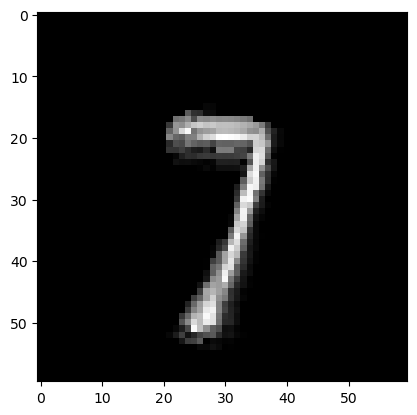

tensor(7)


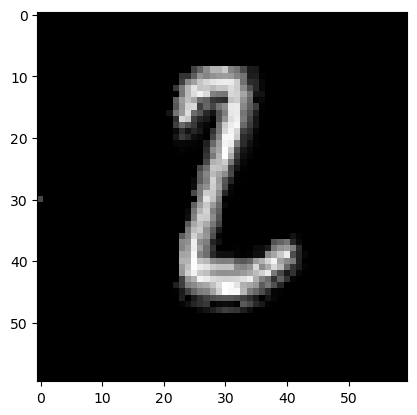

tensor(2)


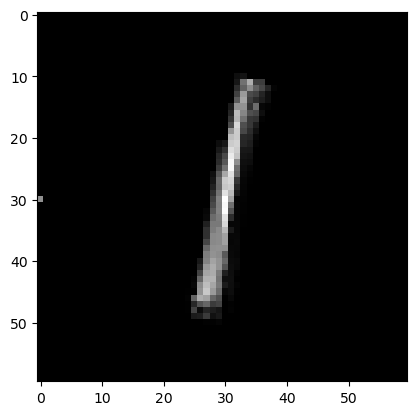

tensor(1)


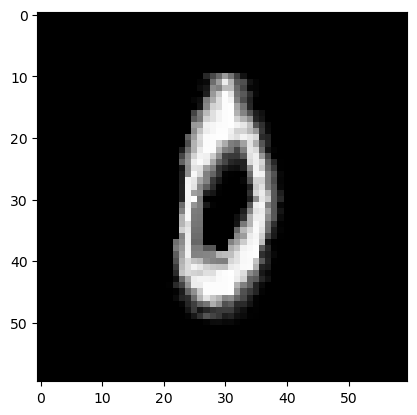

tensor(0)


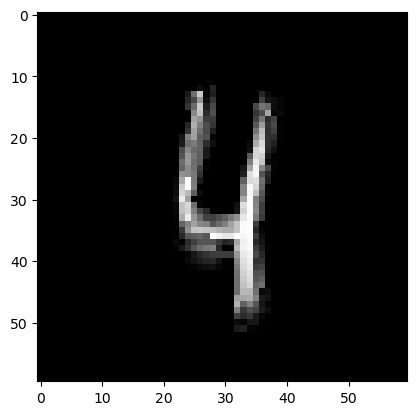

tensor(4)


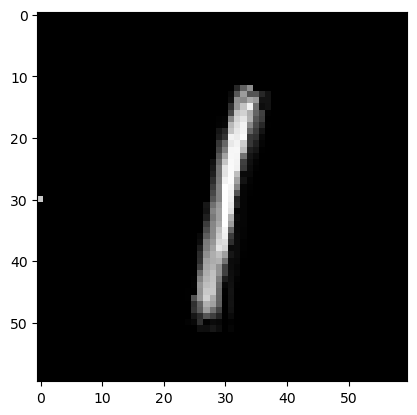

tensor(1)


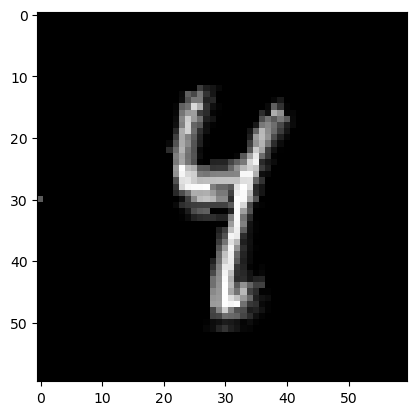

tensor(4)


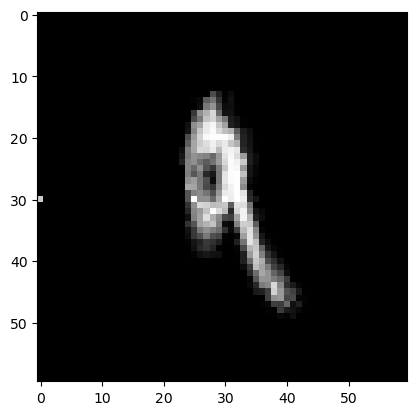

tensor(9)


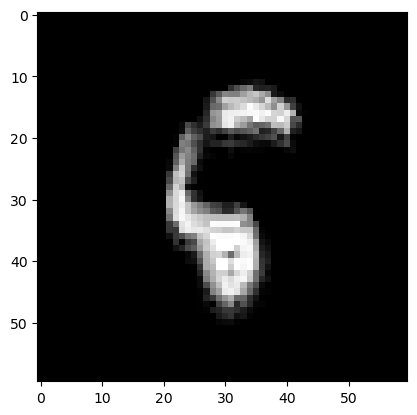

tensor(5)


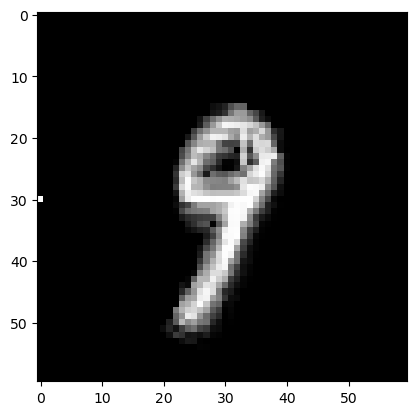

tensor(9)


In [16]:
for i in range(10):
    plt.imshow(test_data_mixed[i][0][0], cmap='gray')
    plt.show()
    print(test_data_mixed[i][1])

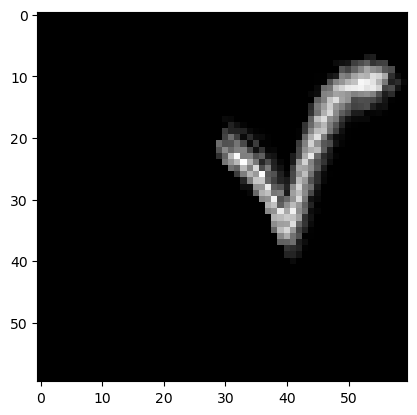

tensor(7)


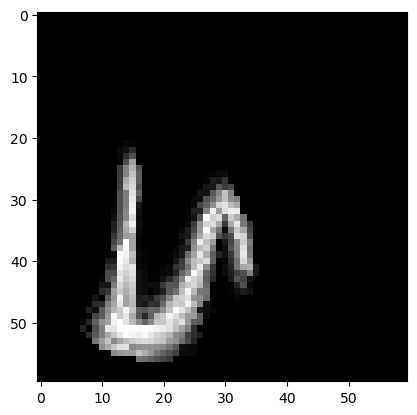

tensor(2)


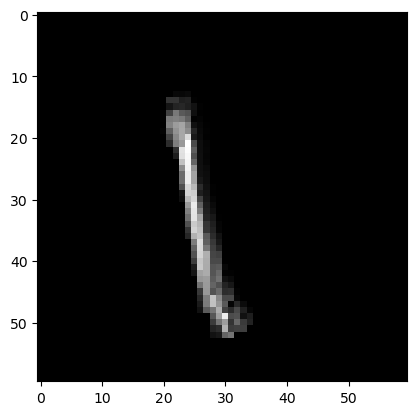

tensor(1)


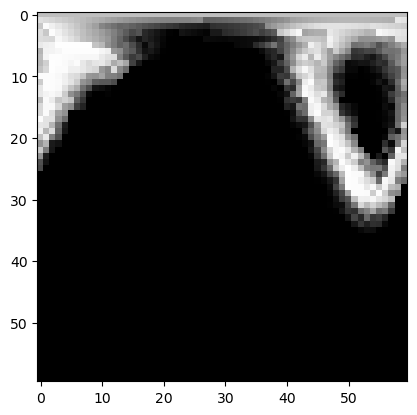

tensor(0)


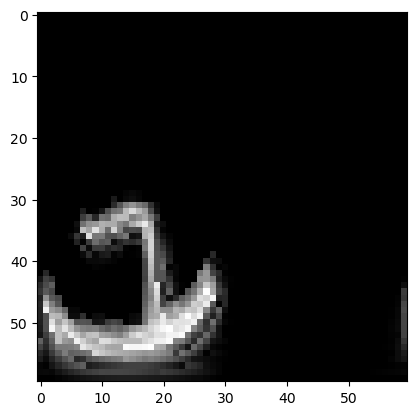

tensor(4)


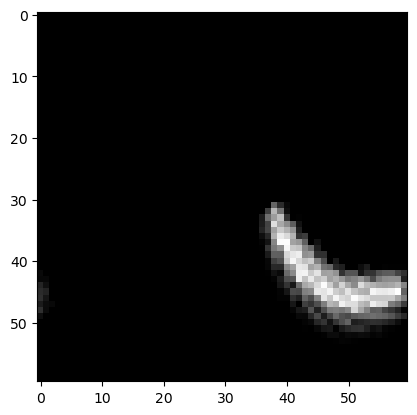

tensor(1)


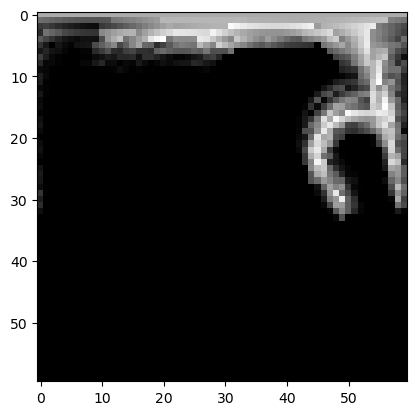

tensor(4)


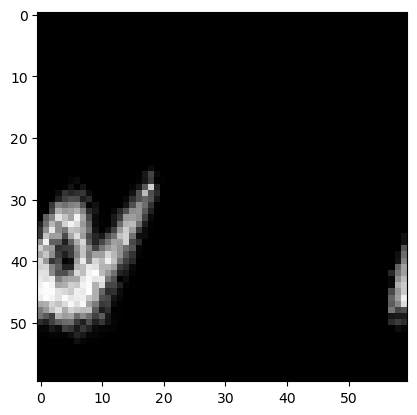

tensor(9)


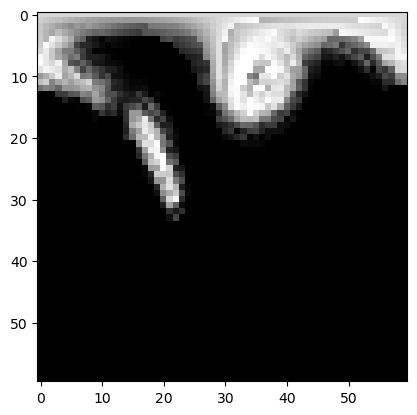

tensor(5)


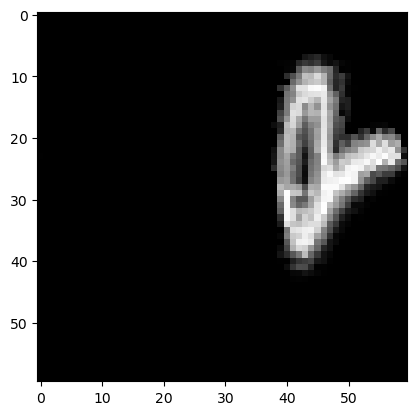

tensor(9)


In [15]:
for i in range(10):
    plt.imshow(test_data_orig[i][0][0], cmap='gray')
    plt.show()
    print(test_data_mixed[i][1])

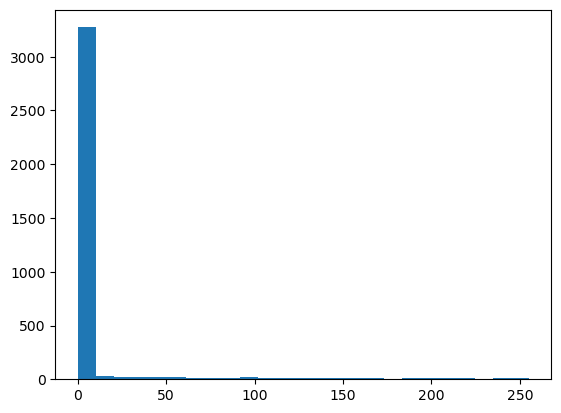

In [10]:
plt.hist(test_data_mixed[0][0][0].flatten(), bins=25)
plt.show()

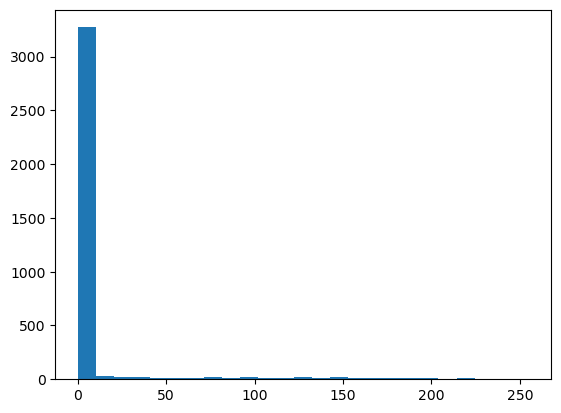

In [11]:
plt.hist(test_data_orig[0][0][0].flatten(), bins=25)
plt.show()

In [12]:
test_data_orig[0][0]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [13]:
for i in range(10):
    x_orig = test_data_orig[i][0].unsqueeze(0).cuda()
    x_mixed = test_data_mixed[i][0].unsqueeze(0).cuda()

    model_orig.eval()
    print(torch.argmax(model_orig(x_orig)).item(), torch.argmax(model_orig(x_mixed)).item(), test_data_orig[i][1].item())

7 5 7
2 5 2
1 1 1
0 0 0
4 2 4
1 1 1
4 2 4
9 2 9
5 2 5
9 6 9


In [14]:
torch.allclose(test_data_orig[:][1], test_data_mixed[:][1])

True